Running experiment with params: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.3234, Train Acc: 53.05%, Test Loss: 0.9772, Test Acc: 65.93%, F1 Score: 0.6546
Epoch 2/10, Train Loss: 1.0112, Train Acc: 64.57%, Test Loss: 0.8759, Test Acc: 69.32%, F1 Score: 0.6932
Epoch 3/10, Train Loss: 0.8611, Train Acc: 69.74%, Test Loss: 0.7934, Test Acc: 72.56%, F1 Score: 0.7234
Epoch 4/10, Train Loss: 0.7544, Train Acc: 73.97%, Test Loss: 0.7760, Test Acc: 73.29%, F1 Score: 0.7341
Epoch 5/10, Train Loss: 0.6644, Train Acc: 76.76%, Test Loss: 0.7640, Test Acc: 74.03%, F1 Score: 0.7372
Epoch 6/10, Train Loss: 0.5939, Train Acc: 79.23%, Test Loss: 0.7442, Test Acc: 74.65%, F1 Score: 0.7446
Epoch 7/10, Train Loss: 0.5291, Train Acc: 81.43%, Test Loss: 0.7711, Test Acc: 75.27%, F1 Score: 0.7513
Epoch 8/10, Train Loss: 0.4709, Train Acc: 83.50%, Test Loss: 0.7793, Test Acc: 75.43%, F1 Score

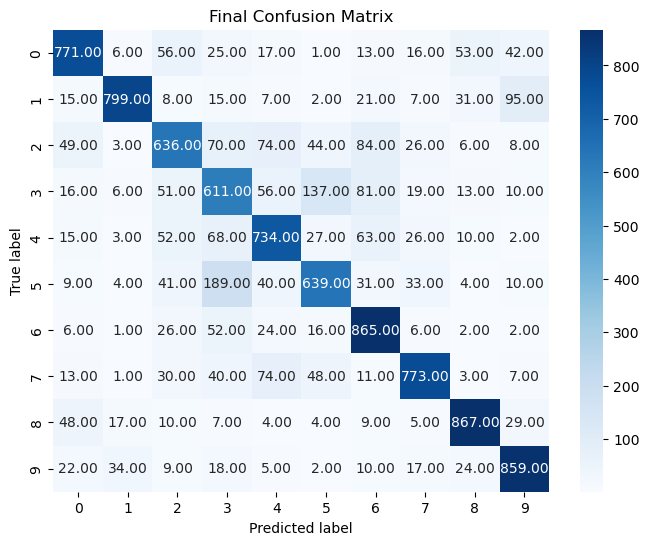

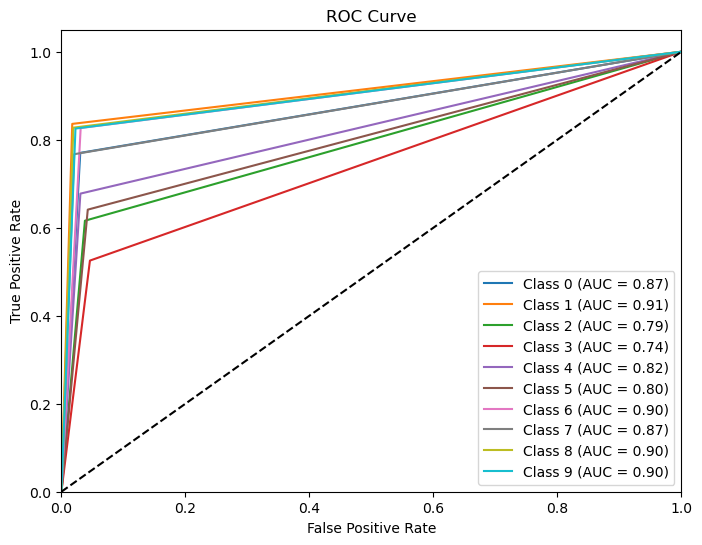

2024/12/01 17:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 128, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.3337, Train Acc: 52.49%, Test Loss: 0.9966, Test Acc: 63.70%, F1 Score: 0.6328
Epoch 2/10, Train Loss: 0.9715, Train Acc: 65.79%, Test Loss: 0.8614, Test Acc: 69.82%, F1 Score: 0.6955
Epoch 3/10, Train Loss: 0.8146, Train Acc: 71.52%, Test Loss: 0.7981, Test Acc: 72.35%, F1 Score: 0.7223
Epoch 4/10, Train Loss: 0.6911, Train Acc: 75.72%, Test Loss: 0.7718, Test Acc: 73.48%, F1 Score: 0.7338
Epoch 5/10, Train Loss: 0.5977, Train Acc: 79.01%, Test Loss: 0.7773, Test Acc: 73.92%, F1 Score: 0.7382
Epoch 6/10, Train Loss: 0.5071, Train Acc: 82.02%, Test Loss: 0.7778, Test Acc: 74.37%, F1 Score: 0.7411
Epoch 7/10, Train Loss: 0.4287, Train Acc: 84.85%, Test Loss: 0.7776, Test Acc: 75.33%, F1 Score: 0.7529
Epoch 8/10, Train Loss: 0.3712, Train Acc: 86.88%, Test Loss: 0.7937, 

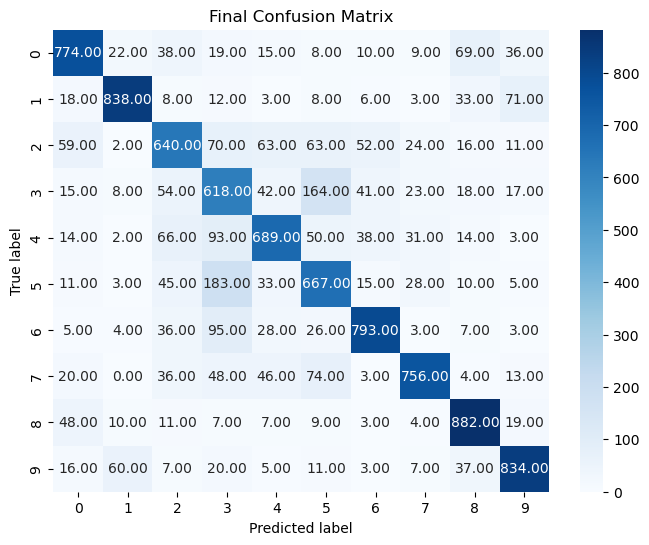

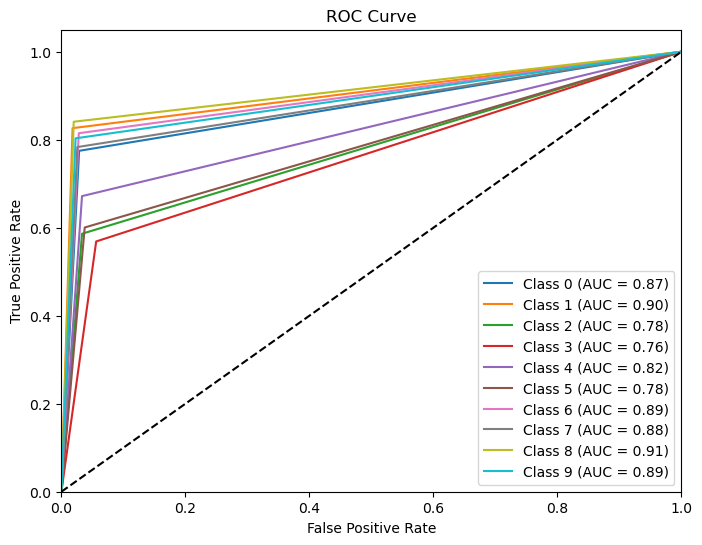

2024/12/01 17:44:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Define the CNN model with dropout and batch normalization
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 64, "learning_rate": 0.001, "num_epochs": 10},
        {"batch_size": 128, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.2041, Train Acc: 57.34%, Test Loss: 0.8489, Test Acc: 70.09%, F1 Score: 0.7022
Epoch 2/10, Train Loss: 0.7987, Train Acc: 72.35%, Test Loss: 0.7110, Test Acc: 75.79%, F1 Score: 0.7568
Epoch 3/10, Train Loss: 0.6219, Train Acc: 78.30%, Test Loss: 0.6761, Test Acc: 77.13%, F1 Score: 0.7684
Epoch 4/10, Train Loss: 0.4829, Train Acc: 83.26%, Test Loss: 0.6194, Test Acc: 79.33%, F1 Score: 0.7945
Epoch 5/10, Train Loss: 0.3794, Train Acc: 86.68%, Test Loss: 0.6535, Test Acc: 79.64%, F1 Score: 0.7964
Epoch 6/10, Train Loss: 0.2916, Train Acc: 89.74%, Test Loss: 0.6687, Test Acc: 79.68%, F1 Score: 0.7965
Epoch 7/10, Train Loss: 0.2285, Train Acc: 91.96%, Test Loss: 0.6961, Test Acc: 80.49%, F1 Score: 0.8045
Epoch 8/10, Train Loss: 0.1930, Train Acc: 93.15%, Test Loss: 0.7315, Test Acc: 80.95%, F1 Scor

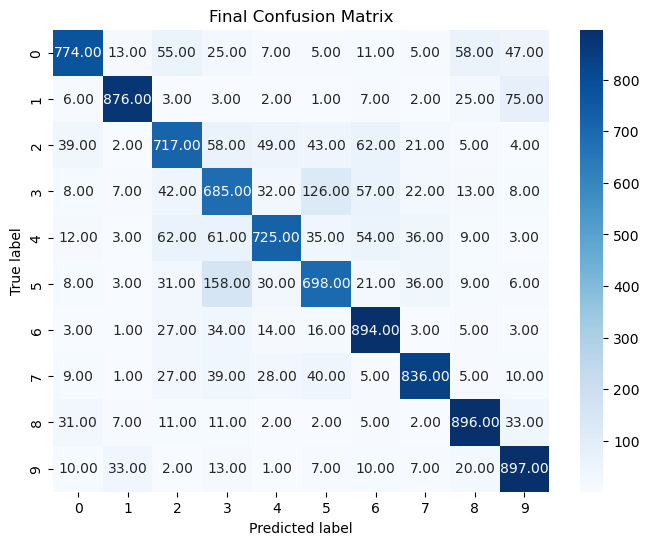

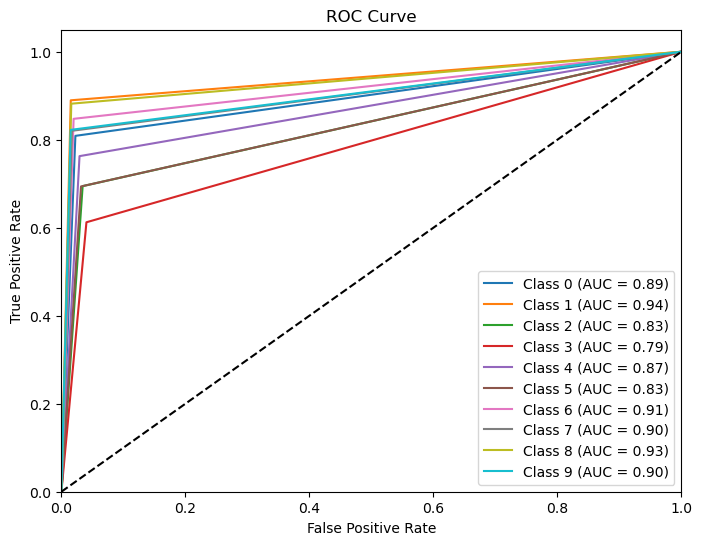

2024/12/01 18:04:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 64, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.1874, Train Acc: 57.83%, Test Loss: 0.8724, Test Acc: 69.08%, F1 Score: 0.6885
Epoch 2/10, Train Loss: 0.7881, Train Acc: 72.50%, Test Loss: 0.7213, Test Acc: 75.25%, F1 Score: 0.7525
Epoch 3/10, Train Loss: 0.5918, Train Acc: 79.34%, Test Loss: 0.6562, Test Acc: 77.26%, F1 Score: 0.7732
Epoch 4/10, Train Loss: 0.4534, Train Acc: 84.09%, Test Loss: 0.6359, Test Acc: 78.67%, F1 Score: 0.7864
Epoch 5/10, Train Loss: 0.3357, Train Acc: 88.11%, Test Loss: 0.6634, Test Acc: 78.78%, F1 Score: 0.7870
Epoch 6/10, Train Loss: 0.2393, Train Acc: 91.57%, Test Loss: 0.6907, Test Acc: 79.79%, F1 Score: 0.7974
Epoch 7/10, Train Loss: 0.1866, Train Acc: 93.46%, Test Loss: 0.7366, Test Acc: 79.70%, F1 Score: 0.7972
Epoch 8/10, Train Loss: 0.1503, Train Acc: 94.74%, Test Loss: 0.7685, T

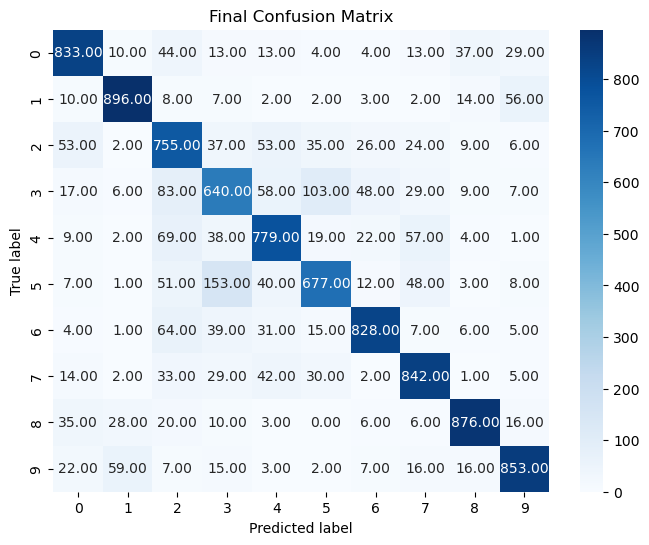

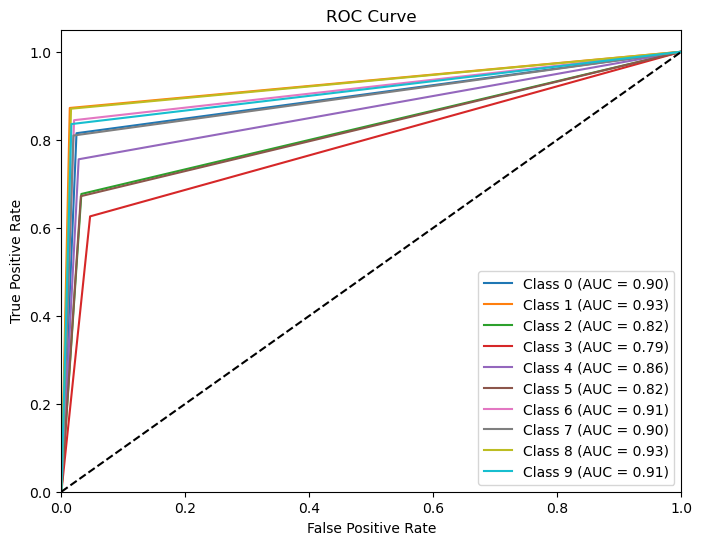

2024/12/01 18:23:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Define the improved CNN model with dropout, batch normalization, and additional layers
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Increase the number of filters
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters for more feature extraction
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Added an extra convolutional layer
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),  # Increased the size of the fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = ImprovedCNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0003, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0003, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 16, 'learning_rate': 0.0001, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.3527, Train Acc: 51.89%, Test Loss: 1.0152, Test Acc: 64.13%, F1 Score: 0.6357
Epoch 2/10, Train Loss: 0.9971, Train Acc: 64.99%, Test Loss: 0.8714, Test Acc: 68.70%, F1 Score: 0.6850
Epoch 3/10, Train Loss: 0.8422, Train Acc: 70.59%, Test Loss: 0.8115, Test Acc: 71.37%, F1 Score: 0.7111
Epoch 4/10, Train Loss: 0.7284, Train Acc: 74.54%, Test Loss: 0.7877, Test Acc: 72.82%, F1 Score: 0.7257
Epoch 5/10, Train Loss: 0.6359, Train Acc: 77.78%, Test Loss: 0.7749, Test Acc: 73.45%, F1 Score: 0.7344
Epoch 6/10, Train Loss: 0.5526, Train Acc: 80.56%, Test Loss: 0.7639, Test Acc: 73.82%, F1 Score: 0.7381
Epoch 7/10, Train Loss: 0.4800, Train Acc: 83.14%, Test Loss: 0.7834, Test Acc: 74.07%, F1 Score: 0.7382
Epoch 8/10, Train Loss: 0.4219, Train Acc: 85.31%, Test Loss: 0.7877, Test Acc: 74.02%, F1 Scor

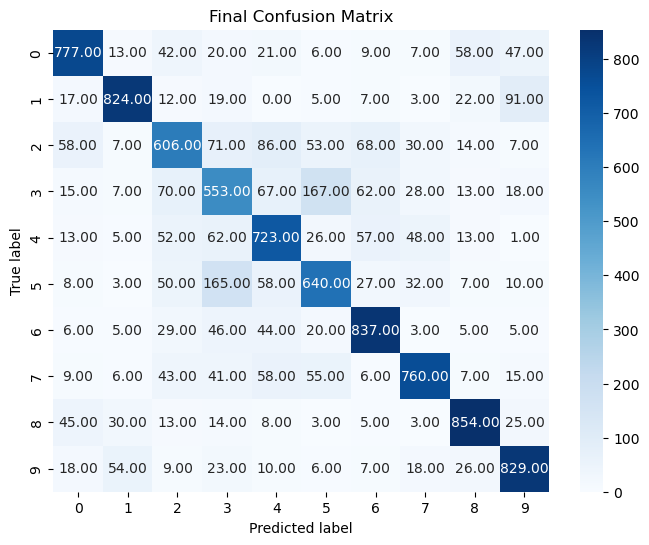

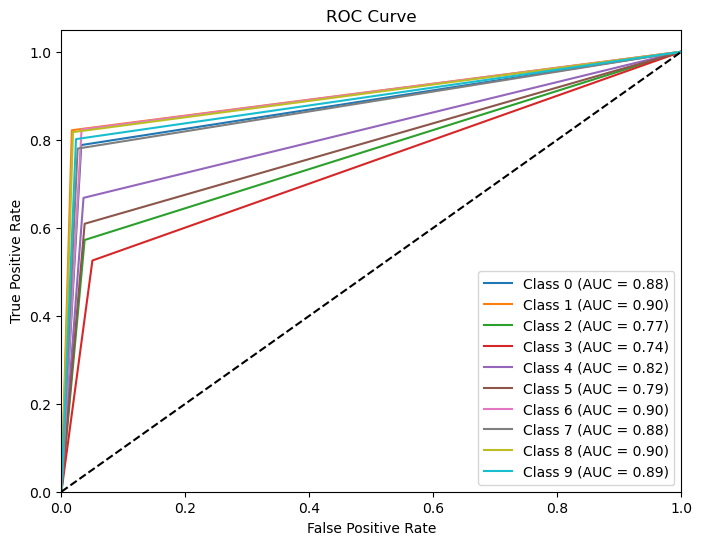

2024/12/01 18:32:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 16, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.3494, Train Acc: 52.15%, Test Loss: 1.0066, Test Acc: 63.92%, F1 Score: 0.6336
Epoch 2/10, Train Loss: 1.0050, Train Acc: 64.94%, Test Loss: 0.8872, Test Acc: 68.81%, F1 Score: 0.6823
Epoch 3/10, Train Loss: 0.8527, Train Acc: 70.10%, Test Loss: 0.8260, Test Acc: 71.54%, F1 Score: 0.7098
Epoch 4/10, Train Loss: 0.7375, Train Acc: 74.28%, Test Loss: 0.7856, Test Acc: 72.76%, F1 Score: 0.7272
Epoch 5/10, Train Loss: 0.6454, Train Acc: 77.49%, Test Loss: 0.7385, Test Acc: 74.33%, F1 Score: 0.7418
Epoch 6/10, Train Loss: 0.5620, Train Acc: 80.33%, Test Loss: 0.7730, Test Acc: 73.81%, F1 Score: 0.7394
Epoch 7/10, Train Loss: 0.4968, Train Acc: 82.44%, Test Loss: 0.8009, Test Acc: 74.68%, F1 Score: 0.7458
Epoch 8/10, Train Loss: 0.4423, Train Acc: 84.29%, Test Loss: 0.8041, T

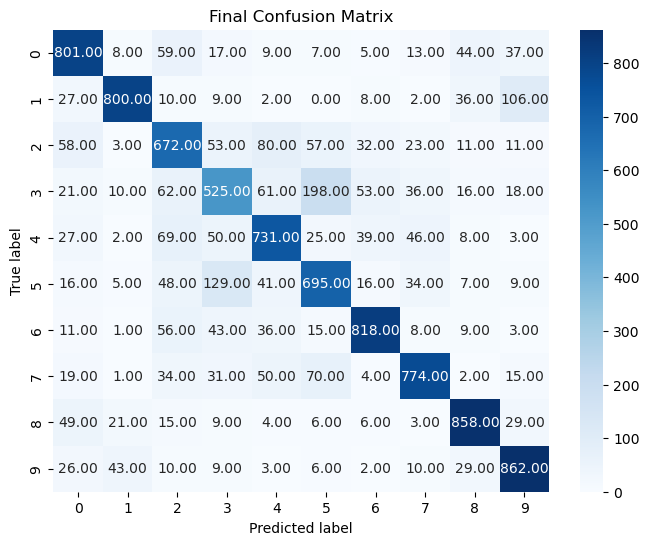

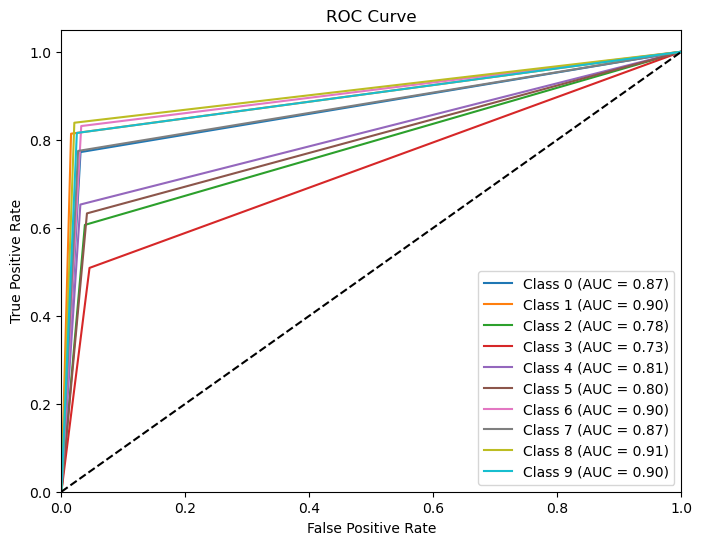

2024/12/01 18:42:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Define the CNN model with dropout and batch normalization
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.0, 0.0), (0.5, 0.5, 0.5))  # Normalize the CIFAR-10 dataset
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 16, "learning_rate": 0.0001, "num_epochs": 10},
        {"batch_size": 16, "learning_rate": 0.0003, "num_epochs": 10}   # Added new batch size and learning rate  
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 128, 'learning_rate': 0.003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.6068, Train Acc: 44.06%, Test Loss: 1.1911, Test Acc: 57.79%, F1 Score: 0.5703
Epoch 2/10, Train Loss: 1.2317, Train Acc: 56.87%, Test Loss: 1.1320, Test Acc: 59.86%, F1 Score: 0.5893
Epoch 3/10, Train Loss: 1.0677, Train Acc: 62.97%, Test Loss: 1.1496, Test Acc: 62.55%, F1 Score: 0.6207
Epoch 4/10, Train Loss: 0.9494, Train Acc: 67.26%, Test Loss: 0.9103, Test Acc: 68.97%, F1 Score: 0.6875
Epoch 5/10, Train Loss: 0.8543, Train Acc: 70.40%, Test Loss: 0.8220, Test Acc: 71.05%, F1 Score: 0.7106
Epoch 6/10, Train Loss: 0.7849, Train Acc: 72.77%, Test Loss: 0.8124, Test Acc: 72.95%, F1 Score: 0.7283
Epoch 7/10, Train Loss: 0.7082, Train Acc: 75.47%, Test Loss: 0.8469, Test Acc: 71.12%, F1 Score: 0.7142
Epoch 8/10, Train Loss: 0.6580, Train Acc: 76.90%, Test Loss: 0.8090, Test Acc: 72.71%, F1 Scor

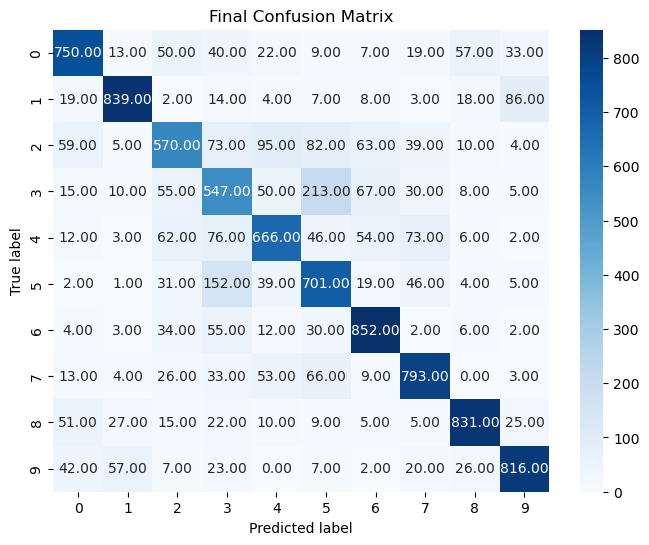

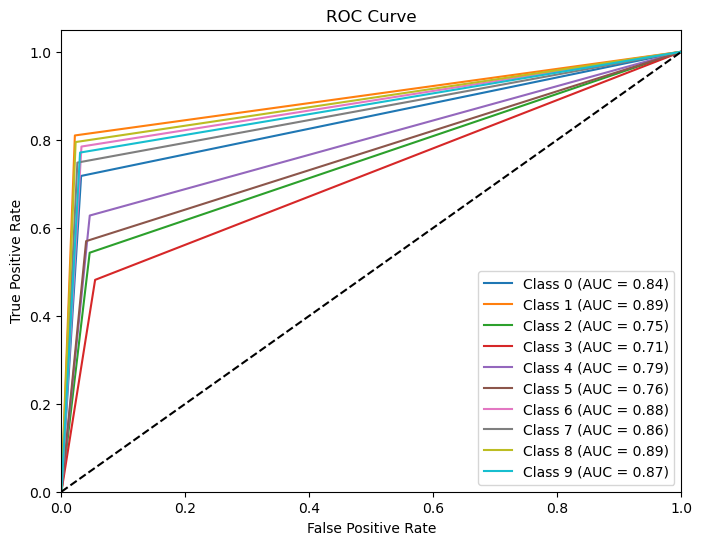

2024/12/01 18:49:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 256, 'learning_rate': 0.003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.5403, Train Acc: 45.63%, Test Loss: 1.2977, Test Acc: 53.46%, F1 Score: 0.5344
Epoch 2/10, Train Loss: 1.1668, Train Acc: 58.98%, Test Loss: 1.0738, Test Acc: 62.43%, F1 Score: 0.6144
Epoch 3/10, Train Loss: 1.0115, Train Acc: 64.92%, Test Loss: 0.9399, Test Acc: 66.72%, F1 Score: 0.6605
Epoch 4/10, Train Loss: 0.8997, Train Acc: 68.77%, Test Loss: 0.8651, Test Acc: 70.48%, F1 Score: 0.6993
Epoch 5/10, Train Loss: 0.8150, Train Acc: 71.59%, Test Loss: 0.8469, Test Acc: 71.11%, F1 Score: 0.7117
Epoch 6/10, Train Loss: 0.7330, Train Acc: 74.27%, Test Loss: 0.7794, Test Acc: 73.61%, F1 Score: 0.7353
Epoch 7/10, Train Loss: 0.6642, Train Acc: 76.72%, Test Loss: 1.0280, Test Acc: 66.62%, F1 Score: 0.6694
Epoch 8/10, Train Loss: 0.6176, Train Acc: 78.50%, Test Loss: 0.8967, T

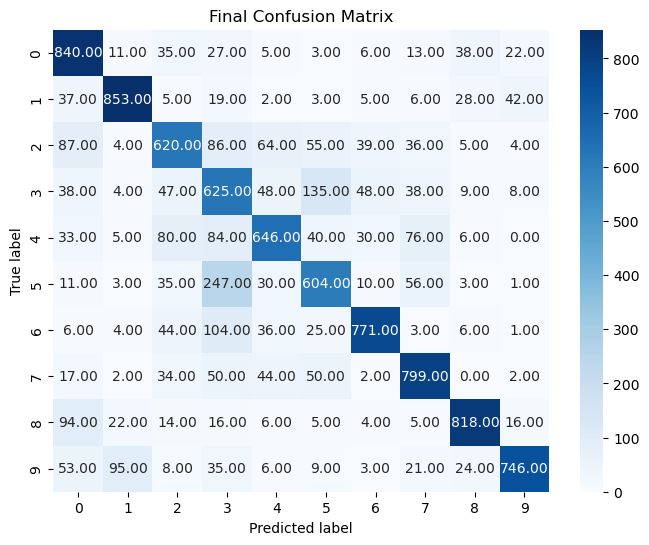

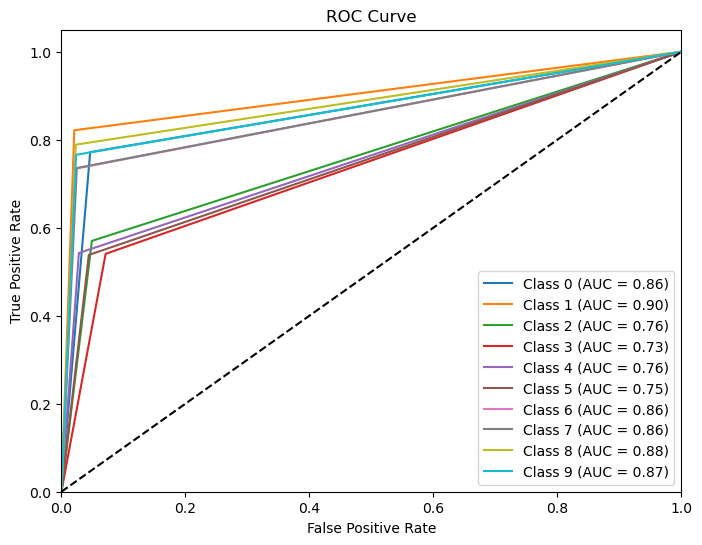

2024/12/01 18:55:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Define the CNN model with dropout and batch normalization
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.0, 0.0), (0.5, 0.5, 0.5))  # Normalize the CIFAR-10 dataset
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 128, "learning_rate": 0.003, "num_epochs": 10},
        {"batch_size": 256, "learning_rate": 0.003, "num_epochs": 10}   # Added new batch size and learning rate  
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.2281, Train Acc: 56.61%, Test Loss: 0.9159, Test Acc: 67.63%, F1 Score: 0.6751
Epoch 2/10, Train Loss: 0.8097, Train Acc: 72.17%, Test Loss: 0.6932, Test Acc: 76.44%, F1 Score: 0.7643
Epoch 3/10, Train Loss: 0.6371, Train Acc: 78.28%, Test Loss: 0.6424, Test Acc: 78.79%, F1 Score: 0.7878
Epoch 4/10, Train Loss: 0.5067, Train Acc: 82.52%, Test Loss: 0.6750, Test Acc: 78.30%, F1 Score: 0.7824
Epoch 5/10, Train Loss: 0.4118, Train Acc: 85.98%, Test Loss: 0.6126, Test Acc: 80.91%, F1 Score: 0.8085
Epoch 6/10, Train Loss: 0.2050, Train Acc: 92.91%, Test Loss: 0.6627, Test Acc: 82.27%, F1 Score: 0.8234
Epoch 7/10, Train Loss: 0.1309, Train Acc: 95.50%, Test Loss: 0.7279, Test Acc: 82.36%, F1 Score: 0.8243
Epoch 8/10, Train Loss: 0.0986, Train Acc: 96.67%, Test Loss: 0.8197, Test Acc: 81.98%, F1 Scor

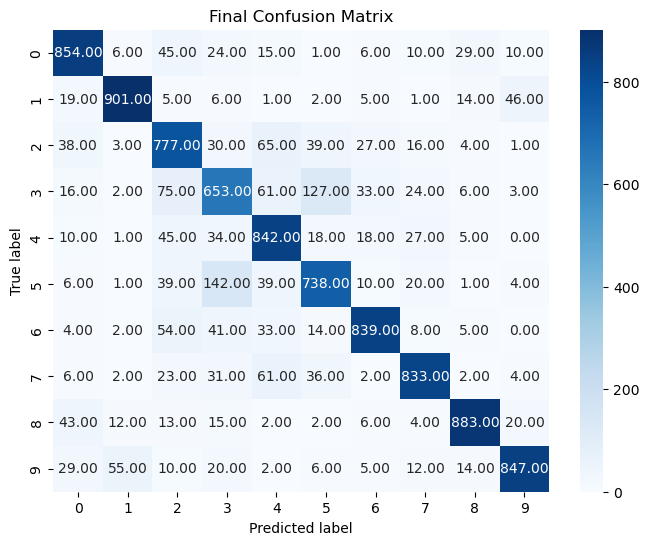

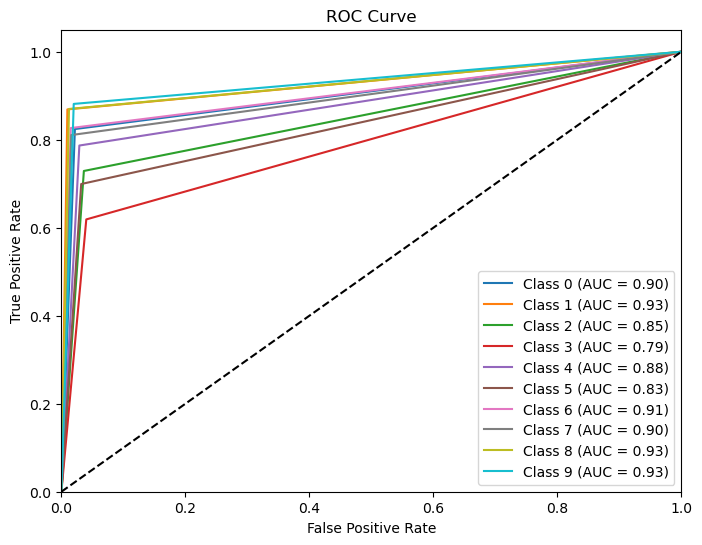

2024/12/01 19:26:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 64, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.1829, Train Acc: 58.10%, Test Loss: 0.8263, Test Acc: 70.71%, F1 Score: 0.7066
Epoch 2/10, Train Loss: 0.7650, Train Acc: 73.59%, Test Loss: 0.6975, Test Acc: 76.19%, F1 Score: 0.7567
Epoch 3/10, Train Loss: 0.5719, Train Acc: 80.40%, Test Loss: 0.6350, Test Acc: 78.67%, F1 Score: 0.7856
Epoch 4/10, Train Loss: 0.4390, Train Acc: 84.91%, Test Loss: 0.6652, Test Acc: 78.62%, F1 Score: 0.7838
Epoch 5/10, Train Loss: 0.3374, Train Acc: 88.48%, Test Loss: 0.6673, Test Acc: 79.62%, F1 Score: 0.7957
Epoch 6/10, Train Loss: 0.1487, Train Acc: 94.85%, Test Loss: 0.6808, Test Acc: 82.15%, F1 Score: 0.8221
Epoch 7/10, Train Loss: 0.0715, Train Acc: 97.61%, Test Loss: 0.8328, Test Acc: 81.79%, F1 Score: 0.8190
Epoch 8/10, Train Loss: 0.0586, Train Acc: 98.02%, Test Loss: 0.9094, T

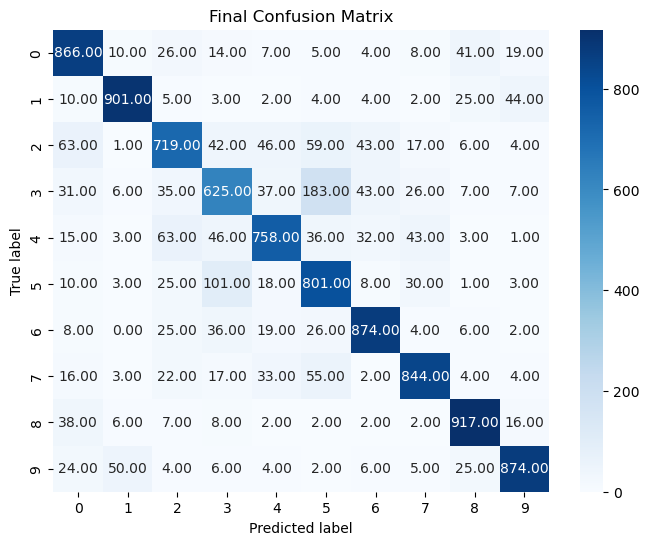

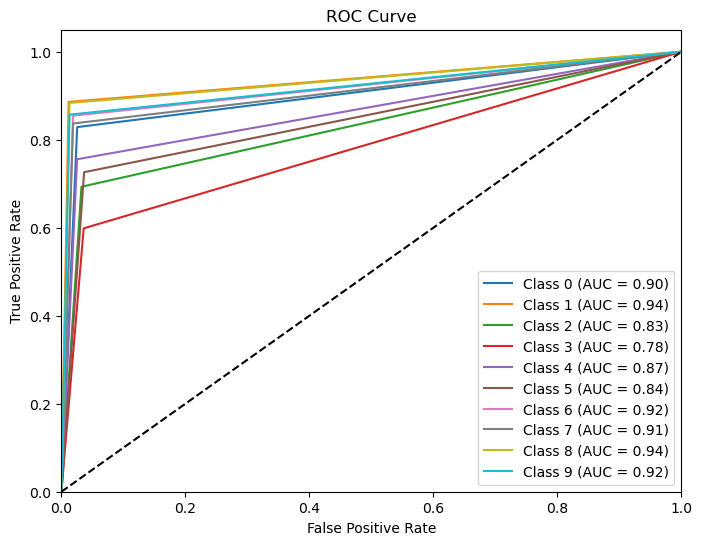

2024/12/01 19:53:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Define the improved CNN model with additional layers, dropout, batch normalization, and global average pooling
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Increase the number of filters
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters for more feature extraction
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Additional convolution layer
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Additional conv layer with more filters
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),  # Increased the size of the fully connected layer
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased dropout to prevent overfitting
            nn.Linear(1024, 10)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = ImprovedCNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0005, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.1976, Train Acc: 57.21%, Test Loss: 0.8745, Test Acc: 68.99%, F1 Score: 0.6918
Epoch 2/10, Train Loss: 0.7794, Train Acc: 73.05%, Test Loss: 0.6876, Test Acc: 76.28%, F1 Score: 0.7598
Epoch 3/10, Train Loss: 0.5986, Train Acc: 79.25%, Test Loss: 0.6470, Test Acc: 77.97%, F1 Score: 0.7794
Epoch 4/10, Train Loss: 0.4601, Train Acc: 84.12%, Test Loss: 0.6307, Test Acc: 79.26%, F1 Score: 0.7939
Epoch 5/10, Train Loss: 0.3501, Train Acc: 87.74%, Test Loss: 0.6728, Test Acc: 79.80%, F1 Score: 0.7983
Epoch 6/10, Train Loss: 0.1606, Train Acc: 94.46%, Test Loss: 0.6751, Test Acc: 81.97%, F1 Score: 0.8189
Epoch 7/10, Train Loss: 0.0929, Train Acc: 96.77%, Test Loss: 0.7816, Test Acc: 81.83%, F1 Score: 0.8179
Epoch 8/10, Train Loss: 0.0693, Train Acc: 97.62%, Test Loss: 0.8776, Test Acc: 80.73%, F1 Scor

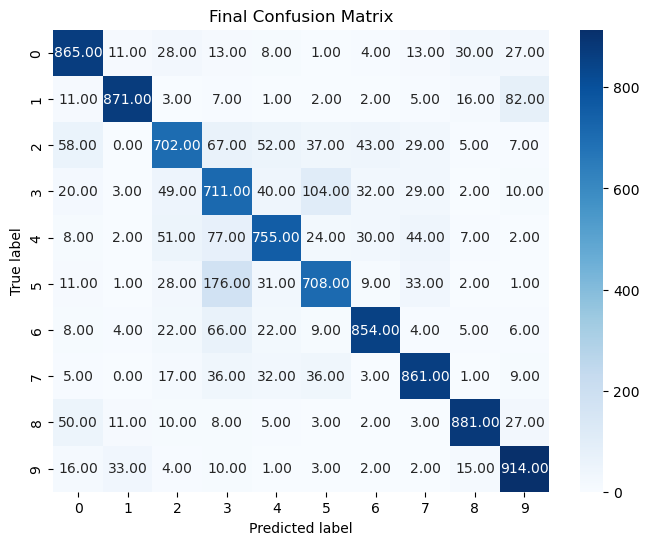

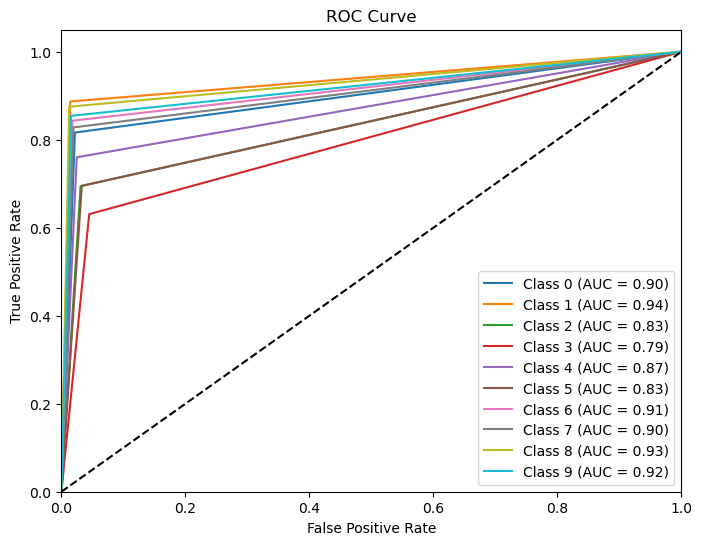

2024/12/01 20:25:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 64, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.2001, Train Acc: 57.10%, Test Loss: 0.8561, Test Acc: 70.06%, F1 Score: 0.6964
Epoch 2/10, Train Loss: 0.7609, Train Acc: 73.49%, Test Loss: 0.7059, Test Acc: 75.07%, F1 Score: 0.7479
Epoch 3/10, Train Loss: 0.5645, Train Acc: 80.31%, Test Loss: 0.6189, Test Acc: 78.67%, F1 Score: 0.7858
Epoch 4/10, Train Loss: 0.4129, Train Acc: 85.65%, Test Loss: 0.6249, Test Acc: 79.48%, F1 Score: 0.7945
Epoch 5/10, Train Loss: 0.2985, Train Acc: 89.72%, Test Loss: 0.6900, Test Acc: 79.32%, F1 Score: 0.7933
Epoch 6/10, Train Loss: 0.1156, Train Acc: 96.12%, Test Loss: 0.7195, Test Acc: 81.57%, F1 Score: 0.8150
Epoch 7/10, Train Loss: 0.0571, Train Acc: 98.05%, Test Loss: 0.8331, Test Acc: 81.28%, F1 Score: 0.8138
Epoch 8/10, Train Loss: 0.0427, Train Acc: 98.54%, Test Loss: 0.9132, T

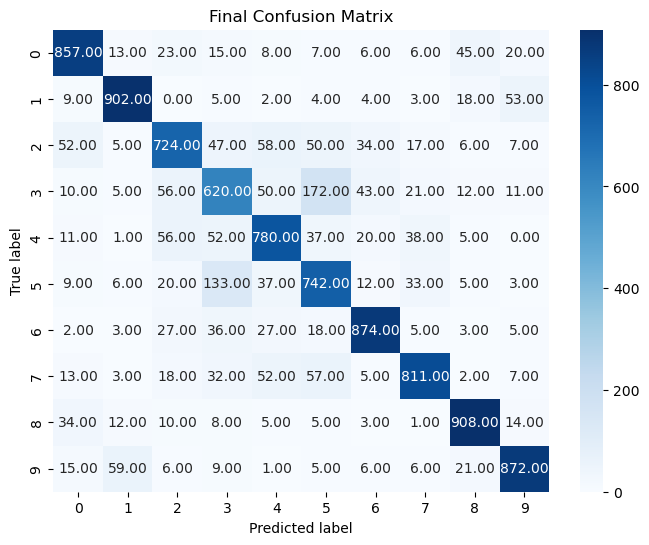

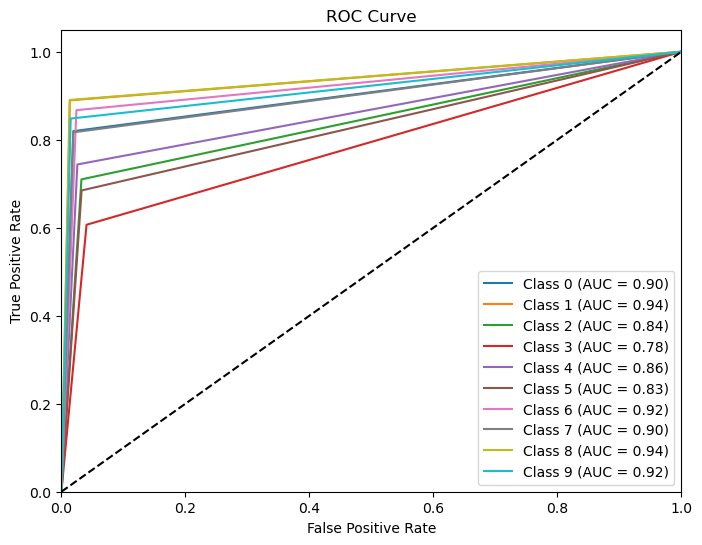

2024/12/01 20:51:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Define the improved CNN model with additional layers, dropout, batch normalization, and global average pooling
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Increase the number of filters
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters for more feature extraction
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Additional convolution layer
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Additional conv layer with more filters
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),  # Increased the size of the fully connected layer
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased dropout to prevent overfitting
            nn.Linear(1024, 10)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = ImprovedCNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0003, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0003, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)
